## Import packages



In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
from torchvision import datasets, transforms
import torchvision.models

torch.manual_seed(1) # set the random seed

In [0]:
def download_and_unzip(filename, target_folder="dataset") -> str:
    if filename[-4:] != ".zip": filename += ".zip"
    url = "http://yucanwu.com/aps360/" + filename

    !cd /content/
    !rm -rf unzip_temp
    !mkdir -p unzip_temp
    !wget $url
    !unzip -qq $filename -d unzip_temp/
    !rm -rf $target_folder
    !mkdir -p $target_folder
    !mv unzip_temp/* $target_folder

    return "/content/" + target_folder + "/"

!rm -rf /content/*
PATH_TRAIN_IM = download_and_unzip("set_a_5600", "train_im")
#PATH_TRAIN_LD = download_and_unzip("set_al_5600", "train_ld") + "dataset_landmasks_auto_5600/"

PATH_VALID_IM = download_and_unzip("set_v_3500", "valid_im") + "dataset_valid/"
#PATH_VALID_LD = download_and_unzip("set_vl_3500", "valid_ld") + "dataset_landmasks_valid/"

# PATH_SMALL_IM = download_and_unzip("set_a_35", "small_im")
# PATH_SMALL_LD = download_and_unzip("set_al_35", "small_ld") + "dataset_landmasks_auto_35/"

# PATH_T_IM = download_and_unzip("set_t_283901", "t_im")
# PATH_T_IM = download_and_unzip("set_t_358514", "t_im")
#PATH_T_LD = download_and_unzip("set_tl_283901", "t_ld") + "dataset_landmasks_train/"
#PATH_EXTRA_IM = download_and_unzip("set_t_358514", "t_im") + "dataset_train"
# PATH_EXTRA_LD = download_and_unzip("set_tl_358514", "t_ld") + "dataset_landmasks_train/"

# PATH_A_IM = download_and_unzip("set_a_460382", "a_im") + "Organized"
# PATH_A_LD = download_and_unzip("set_al_460382", "a_ld") + "dataset_landmasks_auto/"
#PATH_A_IM = download_and_unzip("set_a_460382", "a_im")
#PATH_A_LD = download_and_unzip("set_al_460382", "a_ld") + "dataset_landmasks_auto/"

#PATH_CSV = download_and_unzip("csv.zip", "csv") + "csv/"

!rm *.zip


--2020-04-06 20:18:57--  http://yucanwu.com/aps360/set_a_5600.zip
Resolving yucanwu.com (yucanwu.com)... 207.148.19.24
Connecting to yucanwu.com (yucanwu.com)|207.148.19.24|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-04-06 20:18:57 ERROR 404: Not Found.

unzip:  cannot find or open set_a_5600.zip, set_a_5600.zip.zip or set_a_5600.zip.ZIP.
mv: cannot stat 'unzip_temp/*': No such file or directory
--2020-04-06 20:19:09--  http://yucanwu.com/aps360/set_v_3500.zip
Resolving yucanwu.com (yucanwu.com)... 207.148.19.24
Connecting to yucanwu.com (yucanwu.com)|207.148.19.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58821528 (56M) [application/zip]
Saving to: ‘set_v_3500.zip’

set_v_3500.zip      100%[===================>]  56.10M  27.2MB/s    in 2.1s    

2020-04-06 20:19:11 (27.2 MB/s) - ‘set_v_3500.zip’ saved [58821528/58821528]



## Load model

In [0]:
#!rm -rf /content/*
!git clone https://github.com/Kexin6/RECTnet.git

Cloning into 'RECTnet'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 159 (delta 10), reused 24 (delta 10), pack-reused 134
Receiving objects: 100% (159/159), 436.21 MiB | 31.19 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Checking out files: 100% (94/94), done.


In [0]:
# use_cuda = True
# classes = ['0: Neutral', '1: Happiness', 
#            '2: Sadness', '3: Surprise', 
#            '4: Fear', '5: Disgust', '6: Anger']
# %cd /content

# Seven_nary_tensor_path = "RECTnet/Collection of models/7nary_resnet_model/model_FaceRec_bs128_lr0.001_epoch6"
# Seven_nary_distinguisher = torchvision.models.resnet50(pretrained=True)
# Seven_nary_distinguisher.fc = nn.Linear(512 * 4, 7)
# if use_cuda and torch.cuda.is_available():
#   Seven_nary_distinguisher.cuda()
# Seven_nary_distinguisher.load_state_dict(torch.load(Seven_nary_tensor_path))
# Seven_nary_distinguisher.eval()

# Six_nary_tensor_path = "RECTnet/Collection of models/6nary_model/model_FaceRec_bs128_lr0.0001_epoch2"
# Six_nary_distinguisher = torchvision.models.googlenet(pretrained=True)
# Six_nary_distinguisher.fc = nn.Linear(1024, 6)
# if use_cuda and torch.cuda.is_available():
#   Six_nary_distinguisher.cuda()
# Six_nary_distinguisher.load_state_dict(torch.load(Six_nary_tensor_path))
# Six_nary_distinguisher.eval()

# Five_nary_tensor_path = "RECTnet/Collection of models/5nary_model/model_FaceRec_bs128_lr0.001_epoch3"
# Five_nary_distinguisher = torchvision.models.googlenet(pretrained=True)
# Five_nary_distinguisher.fc = nn.Linear(1024, 5)
# if use_cuda and torch.cuda.is_available():
#   Five_nary_distinguisher.cuda()
# Five_nary_distinguisher.load_state_dict(torch.load(Five_nary_tensor_path))
# Five_nary_distinguisher.eval()

# def run_each_img(input):
#     with torch.no_grad():

#         Seven_nary_test = Seven_nary_distinguisher(input)
#         pred = Seven_nary_test.max(1, keepdim=True)[1]
#         if (pred).cpu().numpy()[0][0] == 1:
#           return 1
#         Six_nary_test = Six_nary_distinguisher(input)
#         pred = Six_nary_test.max(1, keepdim=True)[1]
#         if (pred).cpu().numpy()[0][0] == 0:
#           return 0
#         Five_nary_test = Five_nary_distinguisher(input)
#         pred = Five_nary_test.max(1, keepdim=True)[1]
#         return (pred+2).cpu().numpy()[0][0]

/content


In [0]:
class MyAlexNet(nn.Module):

    def __init__(self, num_classes=1):
        super(MyAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(100, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def my_alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = MyAlexNet(**kwargs)
    return model

use_cuda = True
classes = ['0: Neutral', '1: Happiness', 
           '2: Sadness', '3: Surprise', 
           '4: Fear', '5: Disgust', '6: Anger']
%cd /content
HA_tensor_path = "RECTnet/Collection of models/binary_model/model_HA_distinguisher_bs128_lr0.0001_epoch3"
HA_distinguisher = my_alexnet()
if use_cuda and torch.cuda.is_available():
  print("GPU available")
  torch.cuda.empty_cache()
  HA_distinguisher.cuda()
HA_distinguisher.load_state_dict(torch.load(HA_tensor_path))
HA_distinguisher.eval()


Six_nary_tensor_path = "RECTnet/Collection of models/6nary_model/model_FaceRec_bs128_lr0.0001_epoch2"
Six_nary_distinguisher = torchvision.models.googlenet(pretrained=True)
Six_nary_distinguisher.fc = nn.Linear(1024, 6)
if use_cuda and torch.cuda.is_available():
  Six_nary_distinguisher.cuda()
Six_nary_distinguisher.load_state_dict(torch.load(Six_nary_tensor_path))
Six_nary_distinguisher.eval()

def run_model(input):
    with torch.no_grad():
        out = model(input)
        return out

def run_each_img(input):
    with torch.no_grad():
        HA_test = (HA_distinguisher(input) > 0.0).squeeze().long()
        if HA_test == 1:
          return 1
        Six_nary_test = Six_nary_distinguisher(input)
        pred = Six_nary_test.max(1, keepdim=True)[1]
        if (pred).cpu().numpy()[0][0] == 0:
          return 0
        return (pred+1).cpu().numpy()[0][0]

/content
GPU available


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


In [0]:
# use_cuda = True
# classes = ['0: Neutral', '1: Happiness', 
#            '2: Sadness', '3: Surprise', 
#            '4: Fear', '5: Disgust', '6: Anger']
# %cd /content

# Seven_nary_tensor_path = "RECTnet/Collection of models/7nary_resnet_model/model_FaceRec_bs128_lr0.001_epoch6"
# Seven_nary_distinguisher = torchvision.models.resnet50(pretrained=True)
# Seven_nary_distinguisher.fc = nn.Linear(512 * 4, 7)
# if use_cuda and torch.cuda.is_available():
#   Seven_nary_distinguisher.cuda()
# Seven_nary_distinguisher.load_state_dict(torch.load(Seven_nary_tensor_path))
# Seven_nary_distinguisher.eval()

# Six_nary_tensor_path = "RECTnet/Collection of models/6nary_model/model_FaceRec_bs128_lr0.0001_epoch2"
# Six_nary_distinguisher = torchvision.models.googlenet(pretrained=True)
# Six_nary_distinguisher.fc = nn.Linear(1024, 6)
# if use_cuda and torch.cuda.is_available():
#   Six_nary_distinguisher.cuda()
# Six_nary_distinguisher.load_state_dict(torch.load(Six_nary_tensor_path))
# Six_nary_distinguisher.eval()

# Five_nary_tensor_path = "RECTnet/Collection of models/5nary_model/model_FaceRec_bs128_lr0.001_epoch3"
# Five_nary_distinguisher = torchvision.models.googlenet(pretrained=True)
# Five_nary_distinguisher.fc = nn.Linear(1024, 5)
# if use_cuda and torch.cuda.is_available():
#   Five_nary_distinguisher.cuda()
# Five_nary_distinguisher.load_state_dict(torch.load(Five_nary_tensor_path))
# Five_nary_distinguisher.eval()

# def run_each_img(input):
#     with torch.no_grad():

#         Seven_nary_test = Seven_nary_distinguisher(input)
#         pred = Seven_nary_test.max(1, keepdim=True)[1]
#         if (pred).cpu().numpy()[0][0] == 1:
#           return 1
#         Six_nary_test = Six_nary_distinguisher(input)
#         pred = Six_nary_test.max(1, keepdim=True)[1]
#         if (pred).cpu().numpy()[0][0] == 0:
#           return 0
#         Five_nary_test = Five_nary_distinguisher(input)
#         pred = Five_nary_test.max(1, keepdim=True)[1]
#         return (pred+2).cpu().numpy()[0][0]

/content


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


In [0]:
# use_cuda = True
# classes = ['0: Neutral', '1: Happiness', 
#            '2: Sadness', '3: Surprise', 
#            '4: Fear', '5: Disgust', '6: Anger']
# %cd /content
# HA_tensor_path = "RECTnet/Collection of models/binary_model/model_HA_distinguisher_bs128_lr0.0001_epoch3"
# HA_distinguisher = my_alexnet()
# if use_cuda and torch.cuda.is_available():
#   print("GPU available")
#   torch.cuda.empty_cache()
#   HA_distinguisher.cuda()
# HA_distinguisher.load_state_dict(torch.load(HA_tensor_path))
# HA_distinguisher.eval()

# NE_tensor_path = "/content/model_NE_distinguisher_bs128_lr0.0001_epoch4"
# NE_distinguisher = my_alexnet()
# if use_cuda and torch.cuda.is_available():
#   torch.cuda.empty_cache()
#   NE_distinguisher.cuda()
# NE_distinguisher.load_state_dict(torch.load(NE_tensor_path))
# NE_distinguisher.eval()

# Five_nary_tensor_path = "RECTnet/Collection of models/5nary_model/model_FaceRec_bs128_lr0.001_epoch3"
# Five_nary_distinguisher = torchvision.models.googlenet(pretrained=True)
# Five_nary_distinguisher.fc = nn.Linear(1024, 5)
# if use_cuda and torch.cuda.is_available():
#   torch.cuda.empty_cache()
#   Five_nary_distinguisher.cuda()
# Five_nary_distinguisher.load_state_dict(torch.load(Five_nary_tensor_path))
# Five_nary_distinguisher.eval()

# def run_model(input):
#     with torch.no_grad():
#         out = model(input)
#         return out

# def run_each_img(input):
#     with torch.no_grad():
#         HA_test = (HA_distinguisher(input) > 0.0).squeeze().long()
#         if HA_test == 1:
#           return 1
#         NE_test = (NE_distinguisher(input) > 0.0).squeeze().long()
#         if NE_test == 1:
#           return 0
#         Five_nary_test = Five_nary_distinguisher(input)
#         pred = Five_nary_test.max(1, keepdim=True)[1]
#         return (pred+2).cpu().numpy()[0][0]

/content
GPU available


In [0]:
# use_cuda = True
# classes = ['0: Neutral', '1: Happiness', 
#            '2: Sadness', '3: Surprise', 
#            '4: Fear', '5: Disgust', '6: Anger']
# %cd /content
# HA_tensor_path = "RECTnet/Collection of models/binary_model/model_HA_distinguisher_bs128_lr0.0001_epoch2"
# HA_distinguisher = torchvision.models.googlenet(pretrained=True)
# HA_distinguisher.fc = nn.Linear(1024, 1)
# if use_cuda and torch.cuda.is_available():
#   print("GPU available")
#   torch.cuda.empty_cache()
#   HA_distinguisher.cuda()
# HA_distinguisher.load_state_dict(torch.load(HA_tensor_path))
# HA_distinguisher.eval()


# Six_nary_tensor_path = "RECTnet/Collection of models/6nary_model/model_FaceRec_bs128_lr0.0001_epoch2"
# Six_nary_distinguisher = torchvision.models.googlenet(pretrained=True)
# Six_nary_distinguisher.fc = nn.Linear(1024, 6)
# if use_cuda and torch.cuda.is_available():
#   Six_nary_distinguisher.cuda()
# Six_nary_distinguisher.load_state_dict(torch.load(Six_nary_tensor_path))
# Six_nary_distinguisher.eval()

# def run_model(input):
#     with torch.no_grad():
#         out = model(input)
#         return out

# def run_each_img(input):
#     with torch.no_grad():
#         HA_test = (HA_distinguisher(input) > 0.0).squeeze().long()
#         if HA_test == 1:
#           return 1
#         Six_nary_test = Six_nary_distinguisher(input)
#         pred = Six_nary_test.max(1, keepdim=True)[1]
#         if (pred).cpu().numpy()[0][0] == 0:
#           return 0
#         return (pred+1).cpu().numpy()[0][0]

/content
GPU available


In [0]:

# from PIL import Image
# from torch.utils.data import Dataset, DataLoader
# import pandas as pd
# class FaceDataset(Dataset):
#     """Face Landmarks dataset."""

#     def __init__(self, csv_file, 
#                  image_dir=None, # 'None' disable 
#                  land_dir=None, 
#                  pretrained_dir=None,
#                  transform=None, cache_limit=10000, cache=None,
#                  data_size=None):
#         """
#         Args:
#             csv_file (string): Path to the csv file with annotations.
#             image_dir (string): Directory with all the images.
#             land_dir (string): Directory with all the landmarks images.
#             cache_limit : cache limit
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
#         self.csv = csv_file
#         self.faces = pd.read_csv(csv_file)
#         self.image_dir = image_dir
#         self.land_dir = land_dir
#         self.tensor_dir = pretrained_dir
#         self.transform = transform
#         if cache: self.cache = cache
#         else: self.cache = {}
#         self.cache_limit = cache_limit
#         self.data_size = data_size

#     def clear_cache(self):
#         self.cache.clear()
    
#     def use_global_cache(self, cache):
#         self.cache = cache
        
#     def set_cache_limit(self, cache_limit):
#         if (self.cache_limit < cache_limit):
#             self.clear_cache()
#         self.cache_limit = cache_limit
    
#     def get_cache_size(self):
#         return len(self.cache)
        
#     def __len__(self):
#         if self.data_size: return self.data_size
#         return len(self.faces)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         if isinstance(idx, int):
#             ids = [idx]
#         elif isinstance(idx, slice):
#             stop = idx.stop if idx.stop != None else len(self)
#             ids = list(range(stop))[idx]
        
#         def relative_loc(xy_pair, mins, maxs):
#             orig_x, orig_y = tuple(xy_pair)
#             w = maxs[0] - mins[0]
#             h = maxs[1] - mins[1]
#             x = (orig_x - mins[0]) / w
#             y = (orig_y - mins[1]) / h
#             return np.array([x, y])

#         sample = []
#         for i in ids:
#             h = hash((i, self.csv, self.image_dir, self.land_dir, self.tensor_dir))
#             if h not in self.cache:
#                 row = self.faces.iloc[i, :]
#                 exp = int(row['exp'])
#                 #if exp > 2: exp = 2
#                 # print(i, exp)
#                 # image = cv2.imread(os.path.join(self.image_dir,row['dir']))
#                 image, land_im, tensor_im = ([], [], [])
#                 if self.image_dir: image = Image.open(os.path.join(self.image_dir,row['dir']))
#                 if self.land_dir: land_im = Image.open(os.path.join(self.land_dir,row['dir']))
#                 if self.tensor_dir: tensor_im = torch.load(os.path.join(self.tensor_dir,row['dir'].split('.')[0] + '.tensor'))
#                 landmarks = row['landmarks']
#                 landmarks = np.array([landmarks.split(';')])
#                 landmarks = landmarks.astype('float32').reshape(-1, 2)
#                 mins = landmarks.min(0)
#                 maxs = landmarks.max(0)
#                 landmarks = torch.FloatTensor([relative_loc(xy, mins, maxs) for xy in landmarks])

#                 if self.transform:
#                     if image: image = self.transform(image)
#                     if land_im: land_im = self.transform(land_im)
#                 value = (i, exp, image, land_im, tensor_im, landmarks, row['dir'].split('/')[1].split('.')[0])
#                 if len(self.cache) < self.cache_limit:
#                     self.cache[h] = value
#             else:
#                 value = self.cache[h]
#                 #print("used cache", len(self.cache))
#             sample.append(value)
        
#         if isinstance(idx, int): return sample[0]
#         return sample

# # Good to go
# def get_one_data_loader(path_csv=PATH_CSV + "set_a_5600.csv",
#                         path_im=None, 
#                         path_ld=None,
#                         path_pretrained=None,
#                         transform=None,
#                         batch_size=1, 
#                         num_workers=0):
#     """ NEW dataset class
#     """
#     dataset = FaceDataset(path_csv, path_im, path_ld, path_pretrained,
#                       transform=transform, cache_limit=5000)
#     loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                            num_workers=num_workers, shuffle=True)
#     return loader

In [0]:
# import torchvision.models
# from torchvision.models.googlenet import GoogLeNet
# try:
#     from torch.hub import load_state_dict_from_url
# except ImportError:
#     from torch.utils.model_zoo import load_url as load_state_dict_from_url

# num_classes = 1000
# arch = 'googlenet'
# model_urls = {
#     # GoogLeNet ported from TensorFlow
#     'googlenet': 'https://download.pytorch.org/models/googlenet-1378be20.pth',
# }

# class RECTGoogLeNetV3_1(GoogLeNet):
#     def __init__(self, *args, **kwargs):
#         kwargs['transform_input'] = True
#         kwargs['aux_logits'] = False
#         original_aux_logits = kwargs['aux_logits']
#         kwargs['aux_logits'] = True
#         kwargs['init_weights'] = False

#         super(RECTGoogLeNetV3_1, self).__init__(**kwargs)

#         state_dict = load_state_dict_from_url(model_urls[arch],
#                                               progress=True)
#         super(RECTGoogLeNetV3_1, self).load_state_dict(state_dict)

#         self.aux_logits = False
#         del self.aux1, self.aux2

#         self.fc = nn.Linear(1024, 50)

#         self.name = "RECTGoogLeNetV3_1.1"
        
#         self.b_fc2 = nn.Linear(68 * 2, 128)
#         self.b_fc3 = nn.Linear(128, 128)
#         self.b_fc4 = nn.Linear(128, 128)
#         self.b_fc5 = nn.Linear(128, 128)
#         self.b_fc6 = nn.Linear(128, 20)

#         self.ab_fc = nn.Linear(70, 3)
    
#     def forward(self, x):
#         a = x[0]
#         b = x[1]
        
#         a = super(RECTGoogLeNetV3_1, self).forward(a)
#         a = F.relu(a)

#         # print(b.shape)
          
#         b = b.view(-1, 68 * 2)
#         b = F.dropout(b, training=self.training)
#         b = F.relu(self.b_fc2(b))
#         b = F.dropout(b, training=self.training)
#         b = F.relu(self.b_fc3(b))
#         b = F.dropout(b, training=self.training)
#         b = F.relu(self.b_fc4(b))
#         b = F.dropout(b, training=self.training)
#         b = F.relu(self.b_fc5(b))
#         b = F.dropout(b, training=self.training)
#         b = F.relu(self.b_fc6(b))

#         z = torch.cat((a, b), 1)
#         z = F.dropout(z, training=self.training)
#         z = self.ab_fc(z)

#         return z

# modelV3_1 = RECTGoogLeNetV3_1()

In [0]:
# use_cuda = True
# classes = ['0: Neutral', '1: Happiness', 
#            '2: Sadness', '3: Surprise', 
#            '4: Fear', '5: Disgust', '6: Anger']
# %cd /content

# trinary_path = "/content/model_RECTGoogLeNetV3_1.1_bs72_lr0.0001_epoch1"
# trinary_distinguisher = modelV3_1

# if use_cuda and torch.cuda.is_available():
#   trinary_distinguisher.cuda()
# trinary_distinguisher.load_state_dict(torch.load(trinary_path))
# trinary_distinguisher.eval()

# Five_nary_tensor_path = "RECTnet/Collection of models/5nary_model/model_FaceRec_bs128_lr0.001_epoch3"
# Five_nary_distinguisher = torchvision.models.googlenet(pretrained=True)
# Five_nary_distinguisher.fc = nn.Linear(1024, 5)
# if use_cuda and torch.cuda.is_available():
#   Five_nary_distinguisher.cuda()
# Five_nary_distinguisher.load_state_dict(torch.load(Five_nary_tensor_path))
# Five_nary_distinguisher.eval()

# def run_each_img(input):
#     with torch.no_grad():
#         trinary_test = trinary_distinguisher(input)
#         pred = trinary_test.max(1, keepdim=True)[1]
#         if (pred).cpu().numpy()[0][0] == 1:
#           return 1
#         elif (pred).cpu().numpy()[0][0] == 0:
#           return 0
#         Five_nary_test = Five_nary_distinguisher(input[0])
#         pred = Five_nary_test.max(1, keepdim=True)[1]
#         return (pred+2).cpu().numpy()[0][0]

/content


### Load sample data for testing

### Run tests

Valid Size: 3500


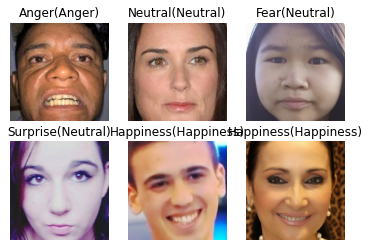

In [0]:
# import os
# from pprint import pprint
# data_transform = transforms.Compose([
#                                     transforms.ToTensor(),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
# cache = {}

# validset = get_one_data_loader(
#     path_csv=PATH_CSV + "set_v_3500.csv",
#     path_im=PATH_VALID_IM, 
#     path_ld=PATH_VALID_LD,
#     path_pretrained=None,
#     transform=data_transform)

# classes = ['Neutral', 'Happiness', 
#            'Sadness', 'Surprise', 
#            'Fear', 'Disgust', 'Anger']

# k = 0
# for idx, labels, images, landmark_imgs, feature, landmarks, filename in validset:
#     image = images[0]
#     #############################################
#     #To Enable GPU Usage
#     if use_cuda and torch.cuda.is_available():
#         torch.cuda.empty_cache()
#         images = images.cuda()
#         landmarks = landmarks.cuda()
#     #############################################
#     output = run_each_img((images, landmarks))

#     img = np.transpose(image, [1,2,0])
#     img = img / 2 + 0.5

#     plt.subplot(2, 3, k+1)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.title(classes[labels[0]]+'(' + classes[output] + ')')
    

#     k += 1
#     if k >= 6:
#         break
# print("Valid Size: {}".format(len(validset)))

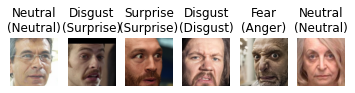

In [0]:
from pprint import pprint

data_path = PATH_VALID_IM
data_transform = transforms.Compose([transforms.Resize(224, 224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.ImageFolder(data_path, transform=data_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                        num_workers=0, shuffle=True)
classes = ['Neutral', 'Happiness', 
           'Sadness', 'Surprise', 
           'Fear', 'Disgust', 'Anger']
k = 0
for images, labels in loader:
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    if use_cuda and torch.cuda.is_available():
          images = images.cuda()
    output = run_each_img(images)
    #result = torch.nn.functional.softmax(output, dim = 1)
    
    #pprint(output)
    #pprint(img[0])

    img = img / 2 + 0.5
    plt.subplot(2, 3, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(classes[labels[0]]+'\n(' + classes[output] + ')')
    

    k += 1
    if k >= 6:
        break

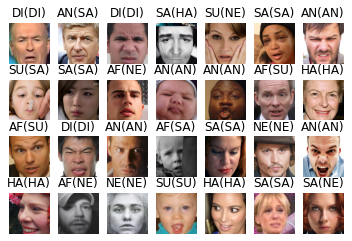

In [0]:
data_path = PATH_VALID_IM
data_transform = transforms.Compose([transforms.Resize(224, 224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.ImageFolder(data_path, transform=data_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                        num_workers=0, shuffle=True)
classes = ['NE','HA','SA','SU','AF','DI','AN']
k = 0
c = 4
r = 7
for images, labels in loader:
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    if use_cuda and torch.cuda.is_available():
          images = images.cuda()
    output = run_each_img(images)
    #result = torch.nn.functional.softmax(output, dim = 1)
    
    #pprint(output)
    #pprint(img[0])

    img = img / 2 + 0.5
    plt.subplot(c, r, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(classes[labels[0]]+'(' + classes[output] + ')')
    

    k += 1
    if k >= r*c:
        break
plt.savefig('result_primary.png')

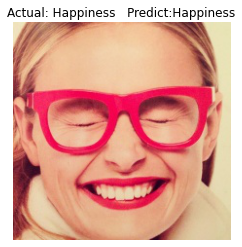

In [0]:
# from pprint import pprint

# data_path = PATH_TRAIN_IM
# data_transform = transforms.Compose([transforms.Resize(224, 224),
#                                         transforms.ToTensor(),
#                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# dataset = datasets.ImageFolder(data_path, transform=data_transform)
# loader = torch.utils.data.DataLoader(dataset, batch_size=1,
#                                         num_workers=0, shuffle=True)
# classes = ['Neutral', 'Happiness', 
#            'Sadness', 'Surprise', 
#            'Fear', 'Disgust', 'Anger']
# k = 0
# for images, labels in loader:
#     image = images[0]
#     # place the colour channel at the end, instead of at the beginning
#     img = np.transpose(image, [1,2,0])
#     # normalize pixel intensity values to [0, 1]
#     if use_cuda and torch.cuda.is_available():
#           images = images.cuda()
#     output = run_each_img(images)
#     #result = torch.nn.functional.softmax(output, dim = 1)
    
#     #pprint(output)
#     #pprint(img[0])
#     if  output != 1:
#       continue
#     img = img / 2 + 0.5
#     plt.subplot(1, 1, k+1)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.title('Actual: '+classes[labels[0]]+'   Predict:' + classes[output])
    
#     plt.savefig('Example.png')
#     k += 1
#     if k >= 1:
#         break


Overall Accuracy: 48.83%


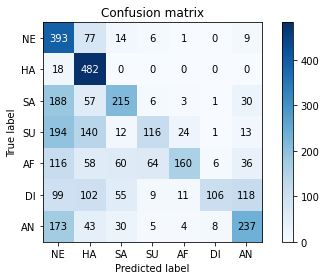

In [0]:
# from sklearn.metrics import confusion_matrix
# def plot_confusion_matrix(classes,
#               normalize=False,
#               title=None,
#               cmap=plt.cm.Blues):

#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     val_feature = get_one_data_loader(
#             path_csv=PATH_CSV + "set_v_3500.csv",
#             path_im=PATH_VALID_IM, 
#             path_ld=PATH_VALID_LD,
#             path_pretrained=None,
#             batch_size=1,
#             transform=data_transform)
    
#     y_true = []
#     y_pred = []
#     total = 0
#     correct = 0
#     with torch.no_grad():  
#         print()
#         for idx, labels, features, landmark_imgs, feature, landmarks, *_ in iter(val_feature): # TODO 
#             #############################################
#             #To Enable GPU Usage
#             if use_cuda and torch.cuda.is_available():
#                 torch.cuda.empty_cache()
#                 features = features.cuda()
#                 landmarks = landmarks.cuda()
#             #############################################
#             pred = run_each_img((features, landmarks))
#             y_pred.append(pred)
#             #print(pred)
#             y_true.append(labels[0].numpy())
#             #print(labels[0].numpy())
#             if pred == labels[0].numpy():
#               correct += 1
#             total += 1
#     print("Overall Accuracy: {:05.2f}%".format(correct*100/total))
#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     fig, ax = plt.subplots()
#     im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
#     # We want to show all ticks...
#     ax.set(
#            # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label')

#     # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
#     return ax, y_true, y_pred

# class_names = ['','NE','HA','SA','SU','AF','DI','AN']
# _, y_true, y_pred = plot_confusion_matrix(classes=class_names,
#                       title='Confusion matrix')
# plt.savefig('primary_model_confusion_matrix.png')
# plt.show()

Overall Accuracy: 54.66%


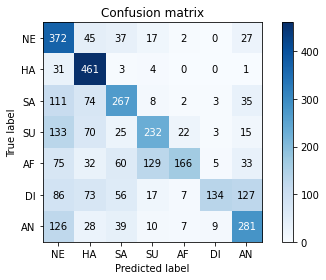

In [0]:
from sklearn.metrics import confusion_matrix
batch_size = 1
def plot_confusion_matrix(classes,
              normalize=False,
              title=None,
              cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #data_path = PATH_TRAIN_IM
    data_path = PATH_VALID_IM
    data_transform = transforms.Compose([transforms.Resize(224, 224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.ImageFolder(data_path, transform=data_transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                             num_workers=0, shuffle=True)
    y_true = []
    y_pred = []
    total = 0
    correct = 0
    with torch.no_grad():  
      for features, labels in iter(loader):
        total += 1
        if use_cuda and torch.cuda.is_available():
          features = features.cuda()
        pred = run_each_img(features)
        y_pred.append(pred)
        #print(pred)
        y_true.append(labels[0].numpy())
        #print(labels[0].numpy())
        if pred == labels[0].numpy():
          correct += 1
        del features
    # Compute confusion matrix
    print("Overall Accuracy: {:05.2f}%".format(correct*100/total))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = ['','NE','HA','SA','SU','AF','DI','AN']
plot_confusion_matrix(classes=class_names,
                      title='Confusion matrix')
plt.savefig('model_confusion_matrix.png')
plt.show()